# Ice Edge Coordinate System Transform Test

In [1]:
import cartopy
import cv2
import cmocean
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
from scipy import io, interpolate
import pyproj

%matplotlib widget

In [2]:
# Load the dataframe
df = pd.read_csv('../../data/play1_df.csv')
# df = df[df['instrument_type'] == 'SWIFT']
df.head()

,Unnamed: 0.1,Unnamed: 0,time,latitude,longitude,hs,wave_direction,wave_direction_mathconv,drift_speed,drift_direction,...,ice edge bearing,ice edge origin lon,ice edge origin lat,along ice drift speed,cross ice drift speed,along ice wind speed,cross ice wind speed,along ice wind corrected drift speed,cross ice wind corrected drift speed,ice concentration
0,0,0,2022-09-09 21:24:00.000004,72.586037,-149.964966,0.815253,52.389679,217.610321,NaN,NaN,...,284.908258,-149.875,72.515909,NaN,NaN,-4.039999,8.984963,NaN,NaN,70.0
1,1,1,2022-09-09 21:36:00.000002,72.587006,-149.976730,0.939075,49.847000,220.153000,0.554840,285.247159,...,284.908258,-149.875,72.515909,0.554830,0.003282,-4.897619,9.149994,0.750735,-0.362718,70.0
2,2,2,2022-09-09 21:48:00.000000,72.587936,-149.988266,0.945042,80.848877,189.151123,0.554722,286.136217,...,284.908258,-149.875,72.515909,0.554594,0.011888,-5.630736,8.755097,0.779824,-0.338316,70.0
3,3,3,2022-09-09 21:59:59.999996,72.589012,-149.999924,0.934823,110.630768,159.369232,0.565919,287.676971,...,284.908258,-149.875,72.515909,0.565258,0.027336,-4.791669,9.181570,0.756925,-0.339926,70.0
4,4,4,2022-09-09 22:12:00.000004,72.590172,-150.011734,0.977387,104.254364,165.745636,0.581481,289.020320,...,284.908258,-149.875,72.515909,0.579984,0.041697,-4.984146,8.826921,0.779350,-0.311380,70.0


In [3]:
def datenum_to_datetime(datenum):
    """
    Convert Matlab datenum into Python datetime.
    :param datenum: Date in datenum format
    :return:        Datetime object corresponding to datenum.
    """
    days = datenum % 1
    return datetime.fromordinal(int(datenum)) \
           + timedelta(days=days) \
           - timedelta(days=366)

2022-09-10 00:00:00


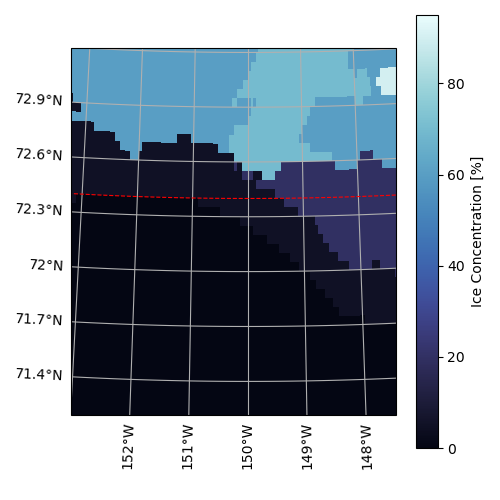

In [4]:
# Load the Gridded Ice Maps
ice_map_data = io.loadmat('../../data/L1/nws_2022.mat')
ice_map_lat = ice_map_data['LAT']
ice_map_lon = ice_map_data['LON']
ice_map_conc = ice_map_data['iceconc'] * 10
ice_map_datenum = np.squeeze(ice_map_data['date'])
ice_map_date = [datenum_to_datetime(ice_map_datenum[n].astype(np.float64)) for n in range(ice_map_datenum.size)]

# Find index of closest Ice Map - September 10th 
ind_for_ice_map = 252
print(ice_map_date[ind_for_ice_map])

# Plot the ice map data
CRS = cartopy.crs.NorthPolarStereo(central_longitude=-150)
FIG_SIZE = (5,5)
EXTENT = [-153, -147.5, 71.2, 73.2]
OCEAN_COLOR = 'blue'

fig, ax = plt.subplots(subplot_kw=dict(projection=CRS), figsize=FIG_SIZE)
ax.set_extent(EXTENT)
ax.set_aspect('equal')
gridlines = ax.gridlines(draw_labels=True, dms=False,
                         x_inline=False, y_inline=False, zorder=0)
gridlines.top_labels = False
gridlines.left_labels = True
gridlines.right_labels = False

# Draw approximate ice edge 
ice_edge_lat = 72.4
ax.gridlines(draw_labels=False, xlocs=[], ylocs=[ice_edge_lat], color='r', linestyle='dashed', label='Approximate Ice Edge')

# Plot the ice map data
im = ax.pcolormesh(ice_map_lon, ice_map_lat, ice_map_conc[:,:,ind_for_ice_map],
                   transform=cartopy.crs.PlateCarree(), cmap=cmocean.cm.ice, zorder=0)
cbar = fig.colorbar(im)
cbar.set_label('Ice Concentration [%]')
plt.tight_layout()

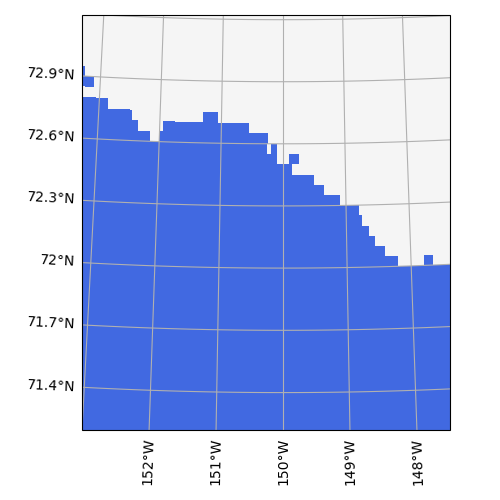

In [5]:
# Compute Ice Edge Based on 15% Concentration
ice_conc_15percent = np.zeros(ice_map_conc[:,:,ind_for_ice_map].shape)
ice_conc_15percent[ice_map_conc[:,:,ind_for_ice_map] >= 15] = 1

# Plot the ice map data
CRS = cartopy.crs.NorthPolarStereo(central_longitude=-150)
FIG_SIZE = (5,5)
EXTENT = [-153, -147.5, 71.2, 73.2]
OCEAN_COLOR = 'blue'

fig, ax = plt.subplots(subplot_kw=dict(projection=CRS), figsize=FIG_SIZE)
ax.set_extent(EXTENT)
ax.set_aspect('equal')
gridlines = ax.gridlines(draw_labels=True, dms=False,
                         x_inline=False, y_inline=False, zorder=0)
gridlines.top_labels = False
gridlines.left_labels = True
gridlines.right_labels = False

# Draw approximate ice edge 
# ax.gridlines(draw_labels=False, xlocs=[], ylocs=[ice_edge_lat], color='r', linestyle='dashed', label='Approximate Ice Edge')

# # Plot locations of SWIFTs and Wavegliders
# im = ax.scatter(df['longitude'], df['latitude'], c='m', s=1, transform=cartopy.crs.PlateCarree())

# Plot the ice map data
cmap = matplotlib.colors.ListedColormap(['royalblue', 'whitesmoke'])
ax.pcolormesh(ice_map_lon, ice_map_lat, ice_conc_15percent,
                   transform=cartopy.crs.PlateCarree(), cmap=cmap, zorder=0)
plt.tight_layout()


In [6]:
# Save the Ice Map
ice_map_array = np.concatenate(ice_map_lon, ice_map_lat, ice_conc_15percent)
np.savetxt('../../data/ice_map.txt', ice_map_array, fmt='%d')
b = np.loadtxt('../../data/ice_map.txt', dtype=int)
ice_map_array == b

TypeError: only integer scalar arrays can be converted to a scalar index

[   nan    nan    nan ... 71.875 71.875 71.875]
[-185.125 -185.075 -185.025 ... -135.225 -135.175 -135.125]


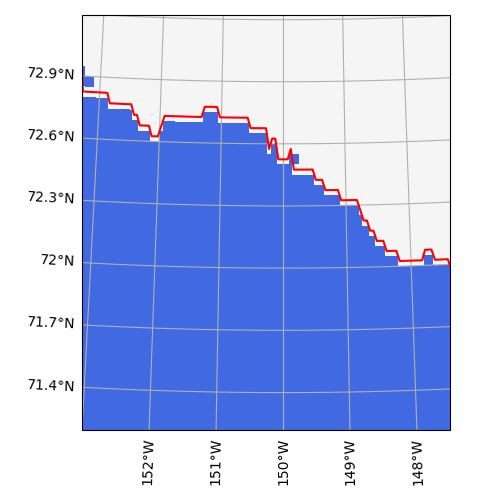

In [6]:
# Find the 15% concentration contour line
ice_edge_contour_lon_vals = ice_map_lon[:,0]
lat_vals = ice_map_lat[0,:]

ice_edge_contour_lat_vals = []

for n in range(ice_conc_15percent.shape[0]):
    ice_edge_lat_index_array = np.where(ice_conc_15percent[n,:] == 1)[0]
    if ice_edge_lat_index_array.size > 0:
        ice_edge_contour_lat_vals.append(lat_vals[ice_edge_lat_index_array[0]])
    else:
        ice_edge_contour_lat_vals.append(np.NaN)

# Convert lon values to numpy array
ice_edge_contour_lat_vals = np.array(ice_edge_contour_lat_vals)
print(ice_edge_contour_lat_vals)
print(ice_edge_contour_lon_vals)

# Plot the ice map data
CRS = cartopy.crs.NorthPolarStereo(central_longitude=-150)
FIG_SIZE = (5,5)
EXTENT = [-153, -147.5, 71.2, 73.2]
OCEAN_COLOR = 'blue'

fig, ax = plt.subplots(subplot_kw=dict(projection=CRS), figsize=FIG_SIZE)
ax.set_extent(EXTENT)
ax.set_aspect('equal')
gridlines = ax.gridlines(draw_labels=True, dms=False,
                         x_inline=False, y_inline=False, zorder=0)
gridlines.top_labels = False
gridlines.left_labels = True
gridlines.right_labels = False

# Draw approximate ice edge 
# ax.gridlines(draw_labels=False, xlocs=[], ylocs=[ice_edge_lat], color='r', linestyle='dashed', label='Approximate Ice Edge')

# # # Plot locations of SWIFTs and Wavegliders
# im = ax.scatter(df['longitude'], df['latitude'], c='m', s=1, transform=cartopy.crs.PlateCarree())

# Plot the ice edge contour
ax.plot(ice_edge_contour_lon_vals, ice_edge_contour_lat_vals, color='r', transform=cartopy.crs.PlateCarree())

# Plot the ice map data
cmap = matplotlib.colors.ListedColormap(['royalblue', 'whitesmoke'])
ax.pcolormesh(ice_map_lon, ice_map_lat, ice_conc_15percent,
                   transform=cartopy.crs.PlateCarree(), cmap=cmap, zorder=0)
plt.tight_layout()


In [7]:
def window_mean_smooth(signal, window_size):
    smoothed_signal = np.zeros_like(signal)

    for i in range(len(signal)):
        window_start = max(0, i - window_size // 2)
        window_end = min(len(signal), i + window_size // 2 + 1)
        smoothed_signal[i] = np.mean(signal[window_start:window_end])

    return smoothed_signal

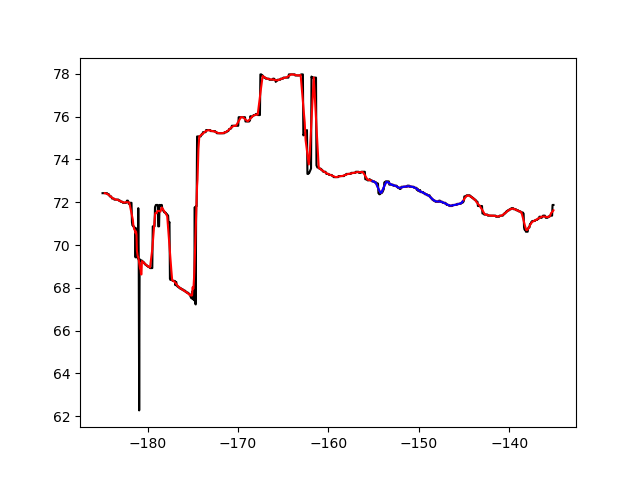

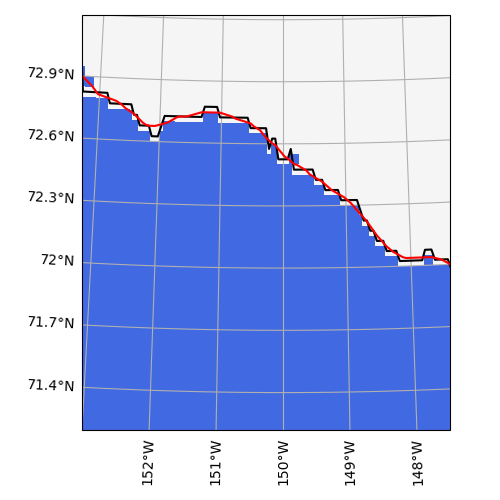

In [8]:
# Smooth the Ice Edge Curve
smooth_ice_edge_contour_lat_vals = window_mean_smooth(ice_edge_contour_lat_vals, 11)

# Extract a subset of the ice edge contour that is relevant to the area of Play 1
ice_edge_contour_lon_play1 = ice_edge_contour_lon_vals[600:800]
ice_edge_contour_lat_play1 = smooth_ice_edge_contour_lat_vals[600:800]

fig, ax = plt.subplots()
ax.plot(ice_edge_contour_lon_vals, ice_edge_contour_lat_vals, color='k')
ax.plot(ice_edge_contour_lon_vals, smooth_ice_edge_contour_lat_vals, color='r')
ax.plot(ice_edge_contour_lon_play1, ice_edge_contour_lat_play1, color='b')

# Plot the ice map data
CRS = cartopy.crs.NorthPolarStereo(central_longitude=-150)
FIG_SIZE = (5,5)
EXTENT = [-153, -147.5, 71.2, 73.2]
OCEAN_COLOR = 'blue'

fig, ax = plt.subplots(subplot_kw=dict(projection=CRS), figsize=FIG_SIZE)
ax.set_extent(EXTENT)
ax.set_aspect('equal')
gridlines = ax.gridlines(draw_labels=True, dms=False,
                         x_inline=False, y_inline=False, zorder=0)
gridlines.top_labels = False
gridlines.left_labels = True
gridlines.right_labels = False

# Draw approximate ice edge 
# ax.gridlines(draw_labels=False, xlocs=[], ylocs=[ice_edge_lat], color='r', linestyle='dashed', label='Approximate Ice Edge')

# # Plot locations of SWIFTs and Wavegliders
# im = ax.scatter(df['longitude'], df['latitude'], c='m', s=1, transform=cartopy.crs.PlateCarree())

# Plot the ice edge contour
ax.plot(ice_edge_contour_lon_vals, ice_edge_contour_lat_vals, color='k', transform=cartopy.crs.PlateCarree())
ax.plot(ice_edge_contour_lon_vals, smooth_ice_edge_contour_lat_vals, color='r', transform=cartopy.crs.PlateCarree())
# ax.plot(ice_edge_contour_lon_play1, ice_edge_contour_lat_play1, color='b', transform=cartopy.crs.PlateCarree())

# Plot the ice map data
cmap = matplotlib.colors.ListedColormap(['royalblue', 'whitesmoke'])
ax.pcolormesh(ice_map_lon, ice_map_lat, ice_conc_15percent,
                   transform=cartopy.crs.PlateCarree(), cmap=cmap, zorder=0)
plt.tight_layout()


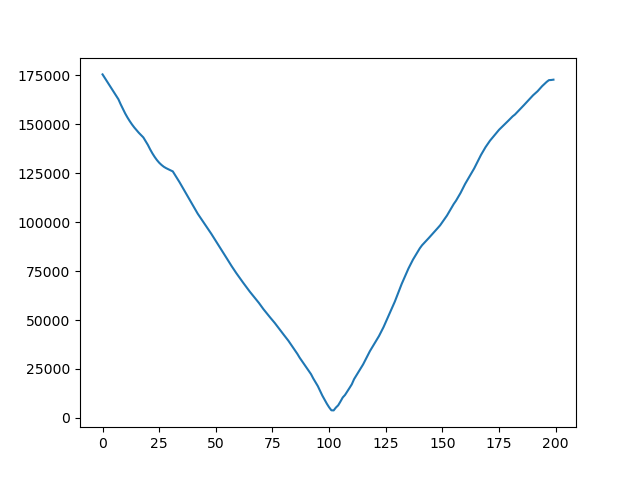

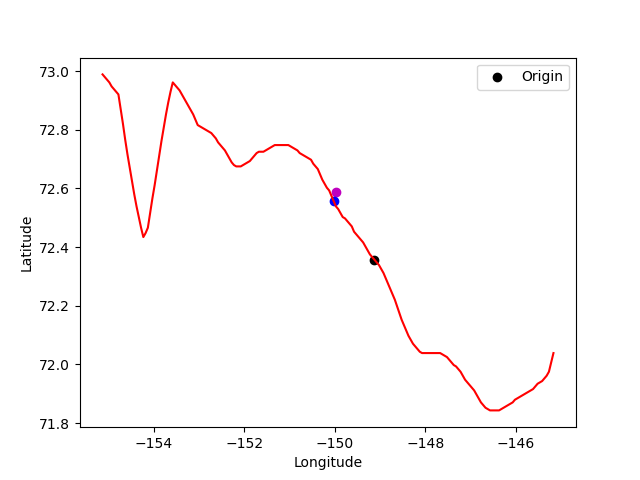

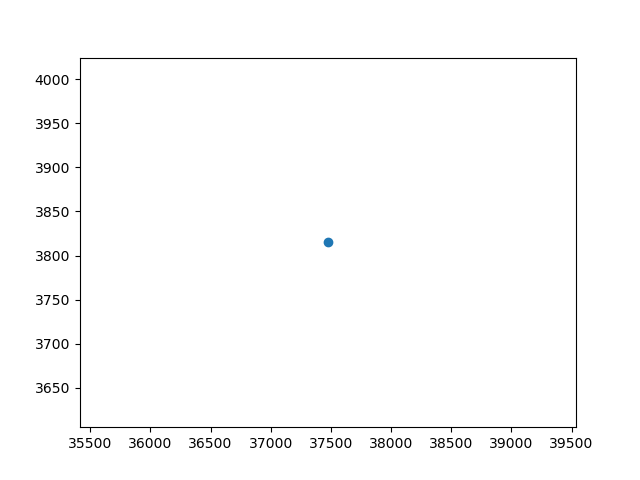

In [9]:
# Convert Tracks to an Along Ice and Cross Ice Edge Coordinate System

# Compute the Euclidean distance between the ice edge and the data point for all points  of the 
n = 0
point_lon = df['longitude'][n]
point_lat = df['latitude'][n]

def haversine_distance(point_lon, point_lat, ice_edge_lon, ice_edge_lat):
    # Radius of the Earth in kilometers
    R = 6371.0
    
    # Convert latitude and longitude from degrees to radians
    point_lat_rad = np.deg2rad(point_lat)
    point_lon_rad = np.deg2rad(point_lon)
    ice_lat_rad = np.deg2rad(ice_edge_lat)
    ice_lon_rad = np.deg2rad(ice_edge_lon)
    
    # Haversine formula
    dlon = point_lon_rad - ice_lon_rad
    dlat = point_lat_rad - ice_lat_rad
    a = np.sin(dlat / 2)**2 + np.cos(point_lat_rad) * np.cos(ice_lat_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    
    # Convert distance from kilometers to meters
    distance_meters = distance * 1000
    
    return distance_meters

# Define along ice origin - this is arbitrary 
along_ice_origin_ind = 120

# Compute the Along Ice Edge Distance
along_ice_distance = haversine_distance(ice_edge_contour_lon_play1[along_ice_origin_ind], 
                                        ice_edge_contour_lat_play1[along_ice_origin_ind], 
                                        ice_edge_contour_lon_play1, ice_edge_contour_lat_play1)

# Compute distance between point and the ice edge
distances = haversine_distance(point_lon, point_lat, ice_edge_contour_lon_play1, ice_edge_contour_lat_play1)
fig, ax = plt.subplots()
ax.plot(distances)

# Find the location of the minimum distance to the ice edge - index for the coordinate transform
ind_of_min_distance = np.argmin(distances)
cross_ice_coord = distances[ind_of_min_distance]
along_ice_coord = along_ice_distance[ind_of_min_distance]

# Plot the true point and location on the ice edge
fig, ax = plt.subplots()
ax.plot(ice_edge_contour_lon_play1, ice_edge_contour_lat_play1, color='r')
ax.scatter(df['longitude'][0], df['latitude'][0], c='m')
ax.scatter(ice_edge_contour_lon_play1[ind_of_min_distance], ice_edge_contour_lat_play1[ind_of_min_distance], color='b')
ax.scatter(ice_edge_contour_lon_play1[along_ice_origin_ind], ice_edge_contour_lat_play1[along_ice_origin_ind], color='k', label='Origin')
ax.legend()
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Plot the point in the ice edge coordinate system
fig, ax = plt.subplots()
ax.scatter(along_ice_coord, cross_ice_coord)


In [10]:
def haversine_distance(point_lon, point_lat, ice_edge_lon, ice_edge_lat):
    # Radius of the Earth in kilometers
    R = 6371.0
    
    # Convert latitude and longitude from degrees to radians
    point_lat_rad = np.deg2rad(point_lat)
    point_lon_rad = np.deg2rad(point_lon)
    ice_lat_rad = np.deg2rad(ice_edge_lat)
    ice_lon_rad = np.deg2rad(ice_edge_lon)
    
    # Haversine formula
    dlon = point_lon_rad - ice_lon_rad
    dlat = point_lat_rad - ice_lat_rad
    a = np.sin(dlat / 2)**2 + np.cos(point_lat_rad) * np.cos(ice_lat_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    
    # Convert distance from kilometers to meters
    distance_meters = distance * 1000
    
    return distance_meters

def ice_edge_coordinate_transform(lons, lats, ice_edge_lons, ice_edge_lats):
    # Define along ice origin - this is arbitrary 
    along_ice_origin_ind = 120

    # Compute the Along Ice Edge Distance
    along_ice_distance = haversine_distance(ice_edge_lons[along_ice_origin_ind], 
                                            ice_edge_lats[along_ice_origin_ind], 
                                            ice_edge_lons, ice_edge_lats)
    
    cross_ice_coords = []
    along_ice_coords = []
    for n in range(lons.size):
        # Compute distance between point and the ice edge
        distances = haversine_distance(lons[n], lats[n], 
                                       ice_edge_contour_lon_play1, 
                                       ice_edge_contour_lat_play1)
        
        ind_of_min_distance = np.argmin(distances)
        cross_ice_coords.append(distances[ind_of_min_distance])
        along_ice_coords.append(along_ice_distance[ind_of_min_distance])

    return cross_ice_coords, along_ice_coords

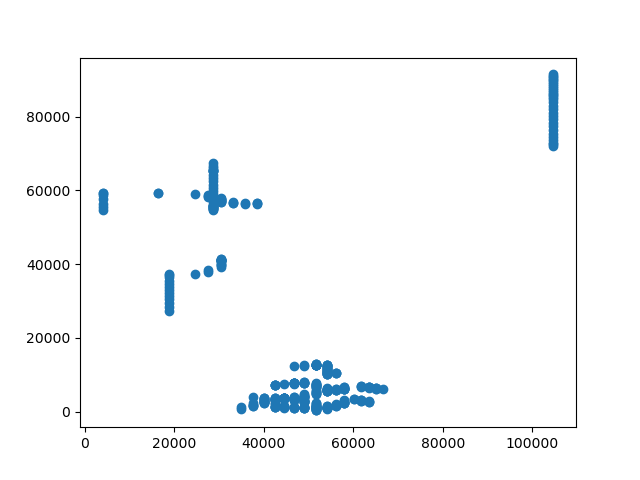

In [11]:
# Transform all coordinates from lon/lat to cross and along ice edge
cross_ice_coords, along_ice_coords = ice_edge_coordinate_transform(df['longitude'], df['latitude'], ice_edge_contour_lon_play1, ice_edge_contour_lat_play1)

# Plot the transformed Coordinates
fig, ax = plt.subplots()
ax.scatter(along_ice_coords, cross_ice_coords)

Well this approach didn't really work - time to try something else

/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_23545/3888725395.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(subplot_kw=dict(projection=CRS), figsize=FIG_SIZE)


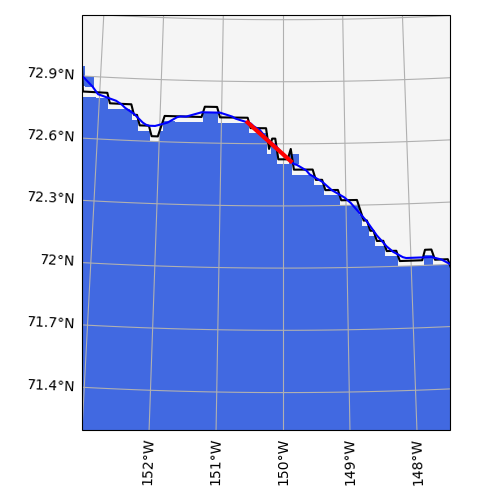

In [27]:
# Define a single line along the segment of interest
# Plot the ice map data
CRS = cartopy.crs.NorthPolarStereo(central_longitude=-150)
FIG_SIZE = (5,5)
EXTENT = [-153, -147.5, 71.2, 73.2]
OCEAN_COLOR = 'blue'

fig, ax = plt.subplots(subplot_kw=dict(projection=CRS), figsize=FIG_SIZE)
ax.set_extent(EXTENT)
ax.set_aspect('equal')
gridlines = ax.gridlines(draw_labels=True, dms=False,
                         x_inline=False, y_inline=False, zorder=0)
gridlines.top_labels = False
gridlines.left_labels = True
gridlines.right_labels = False

# Draw approximate ice edge 
# ax.gridlines(draw_labels=False, xlocs=[], ylocs=[ice_edge_lat], color='r', linestyle='dashed', label='Approximate Ice Edge')

# Plot locations of SWIFTs and Wavegliders
# im = ax.scatter(df['longitude'], df['latitude'], c='m', s=1, transform=cartopy.crs.PlateCarree())

# Plot the ice edge contour
ax.plot(ice_edge_contour_lon_vals, ice_edge_contour_lat_vals, color='k', transform=cartopy.crs.PlateCarree())
# ax.plot(ice_edge_contour_lon_vals, smooth_ice_edge_contour_lat_vals, color='r', transform=cartopy.crs.PlateCarree())
ax.plot(ice_edge_contour_lon_play1, ice_edge_contour_lat_play1, color='b', transform=cartopy.crs.PlateCarree())
line_start_ind = 105
line_end_ind = 91
ax.plot([ice_edge_contour_lon_play1[line_start_ind], ice_edge_contour_lon_play1[line_end_ind]], 
        [ice_edge_contour_lat_play1[line_start_ind], ice_edge_contour_lat_play1[line_end_ind]], 
        color='r', transform=cartopy.crs.PlateCarree(), linewidth=3)

# Plot the ice map data
cmap = matplotlib.colors.ListedColormap(['royalblue', 'whitesmoke'])
ax.pcolormesh(ice_map_lon, ice_map_lat, ice_conc_15percent,
                   transform=cartopy.crs.PlateCarree(), cmap=cmap, zorder=0)
plt.tight_layout()

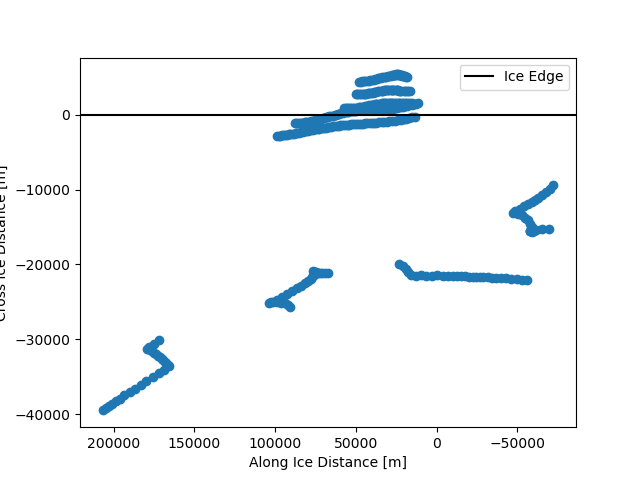

In [31]:
def latlon_to_distances_along_across_line(lat_lon_coords, line_start, line_end):
    """
    
    """
    # Convert latitude and longitude coordinates to numpy arrays for easy manipulation
    lat_lon_coords = np.array(lat_lon_coords)
    line_start = np.array(line_start)
    line_end = np.array(line_end)
    
    # Calculate the direction vector of the line
    line_direction = line_end - line_start
    
    # Calculate the length of the line segment
    line_length = np.linalg.norm(line_direction)
    
    # Normalize the direction vector
    line_direction /= line_length
    
    # Calculate the vector from line_start to each point
    vectors_to_points = lat_lon_coords - line_start
    
    # Calculate the projection of each vector onto the line
    projection_lengths = np.dot(vectors_to_points, line_direction)
    
    # Calculate the projection points on the line
    projection_points = line_start + np.outer(projection_lengths, line_direction)
    
    # Calculate distances along the line from line_start to projection points
    distances_along_line = np.dot(vectors_to_points, line_direction)
    
    # Calculate distances across the line
    # The across distance is the distance between the projection point and the original point
    vectors_across_line = lat_lon_coords - projection_points
    distances_across_line = np.linalg.norm(vectors_across_line, axis=1)
    
    # Calculate the signed distances across the line using the cross product
    cross_product = np.cross(line_direction, vectors_across_line)
    signed_distances_across_line = np.sign(cross_product) * distances_across_line
    
    # Convert distances along and across line from geographical degrees to meters
    # 1 degree of latitude ~= 111.32 km
    # 1 degree of longitude ~= 111.32 km * cos(latitude)
    latitude_conversion_factor = 111320  # meters
    longitude_conversion_factor = 111320 * np.cos(np.radians(line_start[0]))  # meters
    
    distances_along_line_meters = distances_along_line * latitude_conversion_factor
    signed_distances_across_line_meters = signed_distances_across_line * longitude_conversion_factor
    
    return distances_along_line_meters, signed_distances_across_line_meters

line_start_ind = 105 # Note these are flipped so the direction of the line is in the same direction that the SWIFTs are drifting
line_end_ind = 91
line_start = (ice_edge_contour_lat_play1[line_start_ind], ice_edge_contour_lon_play1[line_start_ind])  # Start point of the line
line_end = (ice_edge_contour_lat_play1[line_end_ind], ice_edge_contour_lon_play1[line_end_ind]) # End point of the line

def create_pairs(list1, list2):
    pairs = [(x, y) for x, y in zip(list1, list2)]
    return pairs

lat_lon_coords = create_pairs(df['latitude'], df['longitude'])

along_ice_coords, cross_ice_coords = latlon_to_distances_along_across_line(lat_lon_coords, line_start, line_end)

# Plot the transformed coordinates
fig, ax = plt.subplots()
ax.scatter(along_ice_coords, cross_ice_coords)
ax.axhline(0, label='Ice Edge', color='k')
ax.set_xlabel('Along Ice Distance [m]')
ax.set_ylabel('Cross Ice Distance [m]')
ax.invert_xaxis()
ax.legend()

[ 0.25727207 -0.96633901]
-75.0917419877455
-47.9906484360837
-75.0917419877455


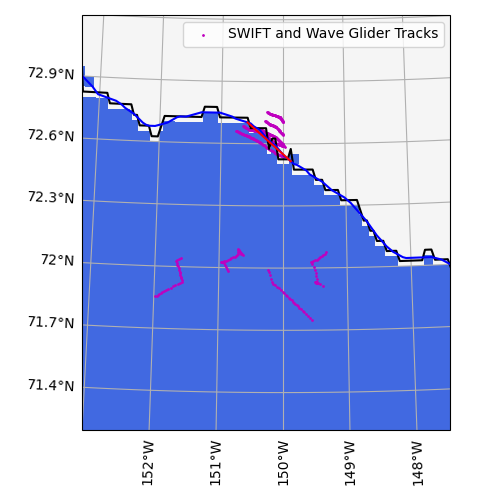

In [36]:
# Get the Bearing and location of the orgin of the new coordinate system and plot to double check
# def get_bearing(lat1, long1, lat2, long2):
#     dLon = (long2 - long1)
#     x = np.cos(np.deg2rad(lat2)) * np.sin(np.deg2rad(dLon))
#     y = np.cos(np.deg2rad(lat1)) * np.sin(np.deg2rad(lat2)) - np.sin(np.deg2rad(lat1)) \
#         * np.cos(np.deg2rad(lat2)) * np.cos(np.deg2rad(dLon))
#     brng = np.arctan2(x,y)
#     brng = np.degrees(brng)

#     return brng

# Calculate the direction vector of the line
line_direction = np.array(line_end) - np.array(line_start)

# Calculate the length of the line segment
line_length = np.linalg.norm(line_direction)

# Normalize the direction vector
line_direction /= line_length
print(line_direction)
line_bearing = np.rad2deg(np.arctan2(line_direction[1], line_direction[0]))
print(line_bearing)

# This should be the correct way but it is getting the wrong direction based on the plot I have - 
# I may need to dig into this some more and see if the scales that I am working on if it is applicable to move
# into this cartesian system or if the data will be totally skewed
geodesic = pyproj.Geod(ellps='WGS84')
ice_edge_coordinate_bearing,back_azimuth,distance = geodesic.inv(ice_edge_contour_lon_play1[line_start_ind], 
                                                                 ice_edge_contour_lat_play1[line_start_ind], 
                                                                 ice_edge_contour_lon_play1[line_end_ind],
                                                                 ice_edge_contour_lat_play1[line_end_ind])

print(ice_edge_coordinate_bearing)
ice_edge_origin_lon = ice_edge_contour_lon_play1[line_start_ind]
ice_edge_origin_lat = ice_edge_contour_lat_play1[line_start_ind]

# df['ice edge bearing'] = np.ones(len(df['latitude'])) * ice_edge_coordinate_bearing
# df['ice edge origin lon'] = np.ones(len(df['latitude'])) * ice_edge_contour_lon_play1[line_start_ind]
# df['ice edge origin lat'] = np.ones(len(df['latitude'])) * ice_edge_contour_lat_play1[line_start_ind]

# Define a single line along the segment of interest
# Plot the ice map data
CRS = cartopy.crs.NorthPolarStereo(central_longitude=-150)
FIG_SIZE = (5,5)
EXTENT = [-153, -147.5, 71.2, 73.2]
OCEAN_COLOR = 'blue'

fig, ax = plt.subplots(subplot_kw=dict(projection=CRS), figsize=FIG_SIZE)
ax.set_extent(EXTENT)
ax.set_aspect('equal')
gridlines = ax.gridlines(draw_labels=True, dms=False,
                         x_inline=False, y_inline=False, zorder=0)
gridlines.top_labels = False
gridlines.left_labels = True
gridlines.right_labels = False

# Plot locations of SWIFTs and Wavegliders
im = ax.scatter(df['longitude'], df['latitude'], c='m', s=1, transform=cartopy.crs.PlateCarree(), label='SWIFT and Wave Glider Tracks')

# Plot the ice edge contour
ax.plot(ice_edge_contour_lon_vals, ice_edge_contour_lat_vals, color='k', transform=cartopy.crs.PlateCarree())
# ax.plot(ice_edge_contour_lon_vals, smooth_ice_edge_contour_lat_vals, color='r', transform=cartopy.crs.PlateCarree())
ax.plot(ice_edge_contour_lon_play1, ice_edge_contour_lat_play1, color='b', transform=cartopy.crs.PlateCarree())
line_start_ind = 105
line_end_ind = 91
ax.plot([ice_edge_contour_lon_play1[line_start_ind], ice_edge_contour_lon_play1[line_end_ind]], 
        [ice_edge_contour_lat_play1[line_start_ind], ice_edge_contour_lat_play1[line_end_ind]], 
        color='r', transform=cartopy.crs.PlateCarree())

# ax.scatter(ice_edge_origin_lon, ice_edge_origin_lat, 
#            s=500, color='y', marker='*', transform=cartopy.crs.PlateCarree(), label='Origin')

# ax.arrow(ice_edge_origin_lon, ice_edge_origin_lat,
#           0.1*np.cos(np.deg2rad(90 - line_bearing)), 
#           0.1*np.sin(np.deg2rad(90 - line_bearing)), color='y', 
#           transform=cartopy.crs.PlateCarree())

# Plot the ice map data
cmap = matplotlib.colors.ListedColormap(['royalblue', 'whitesmoke'])
ax.pcolormesh(ice_map_lon, ice_map_lat, ice_conc_15percent,
                   transform=cartopy.crs.PlateCarree(), cmap=cmap, zorder=0)
plt.tight_layout()
ax.legend()
print(line_bearing)


In [37]:
print(ice_edge_origin_lon)
print( ice_edge_origin_lat)

-149.875
72.51590909090909


In [15]:
np.cos(np.deg2rad(90 - ice_edge_coordinate_bearing))
np.sin(np.deg2rad(90 - ice_edge_coordinate_bearing))


0.6692518902598488

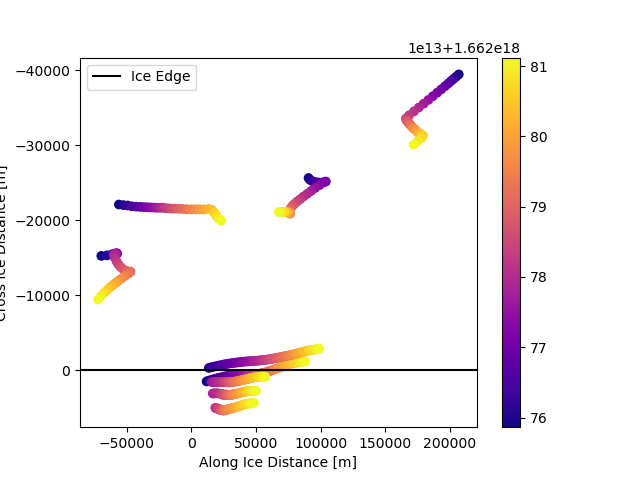

In [16]:
# Plot the locations of the points with the time as the color
fig, ax = plt.subplots()
im = ax.scatter(along_ice_coords, cross_ice_coords, c=pd.to_datetime(df['time']), cmap='plasma')
fig.colorbar(im)
ax.axhline(0, label='Ice Edge', color='k')
ax.set_xlabel('Along Ice Distance [m]')
ax.set_ylabel('Cross Ice Distance [m]')
ax.invert_yaxis()
ax.legend()

In [17]:
# Add the cross ice and along ice coordinates to the dataframe
df['cross ice coord'] = cross_ice_coords
df['along ice coord'] = along_ice_coords

Text(0, 0.5, 'Significant Wave Height [m]')

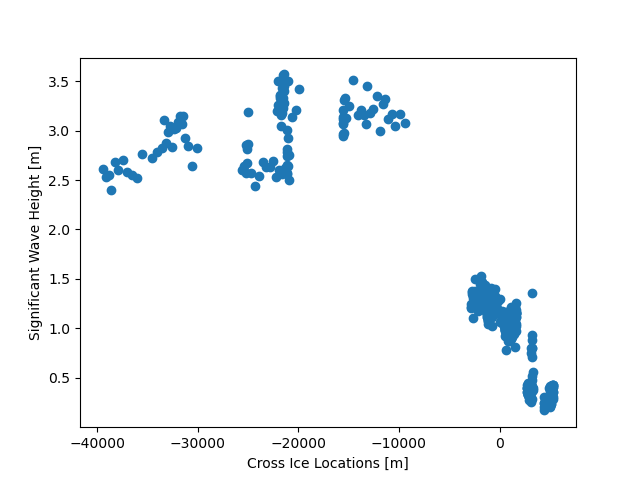

In [18]:
# Look how wave height varies with cross ice coordinate
fig, ax = plt.subplots()
ax.scatter(df['cross ice coord'], df['hs'])
ax.set_xlabel('Cross Ice Locations [m]')
ax.set_ylabel('Significant Wave Height [m]')

In [19]:
ice_conc_f = interpolate.RegularGridInterpolator((ice_map_lat[0,:], ice_map_lon[:,0]), np.transpose(ice_map_conc[:,:,ind_for_ice_map]), 
                                                  method='linear', bounds_error=False)

lat_lon_coords = create_pairs(df['latitude'], df['longitude'])

ice_conc_each_point = []
for n in range(len(lat_lon_coords)):
    ice_conc_each_point.append(ice_conc_f(lat_lon_coords[n]).item())

print(ice_conc_each_point)


[70.0, 70.0, 70.0, 69.99999999999999, 70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 67.20477350055421, 59.664592593902555, 53.29825494437988, 48.05244713090077, 43.94485110416848, 45.91857910156112, 48.279113769530014, 50.986785888670795, 53.93249511718658, 57.13300991803274, 60.62331905588424, 63.884595390408776, 66.89919725060444, 69.47227565571663, 68.4785808902166, 58.595010917629615, 50.03899531438772, 42.58361198008103, 35.70300615392877, 29.765042802323322, 24.82559904456745, 26.463012695313715, 28.60534667968884, 30.400543212892067, 32.146148681642174, 33.69338989257976, 35.69686889648612, 37.26394653320496, 38.77294018864707, 39.491012152285315, 40.41262270882836, 40.420179367066716, 40.41669417172821, 40.69145798683337, 40.813724342735526, 41.05346679687705, 41.68289184570521, 42.16125488281462, 42.740325927736514, 43.218688964845924, 43.71383666992407, 44.25933837890848, 45.12374877929916, 45.996551513674206, 46.81060791015862, 47.64984130859618, 48.32122802734621, 48.78280639648686, 

In [20]:
ice_map_conc[ind_for_ice_map].shape

(501, 365)